In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# [1] https://docs.google.com/document/d/1QnHV33jAytV1AOFISvGnWSSIhK93EyPyHkHIg6Wc2Xw/edit?tab=t.0#heading=h.74ak1339whz6

BLADE_LENGTH = 1.8288  # length of blades
STRUT_LENGTH = 0.7874  # length of strut

CP_TSRs = [(0.3, 3.7), (0.4, 5.2)]  # assumed TSR and power coefficient (Table 3/5.3 in [1])

RHO = 1.225  # air density

r = STRUT_LENGTH
l = BLADE_LENGTH
area = 2*r*l


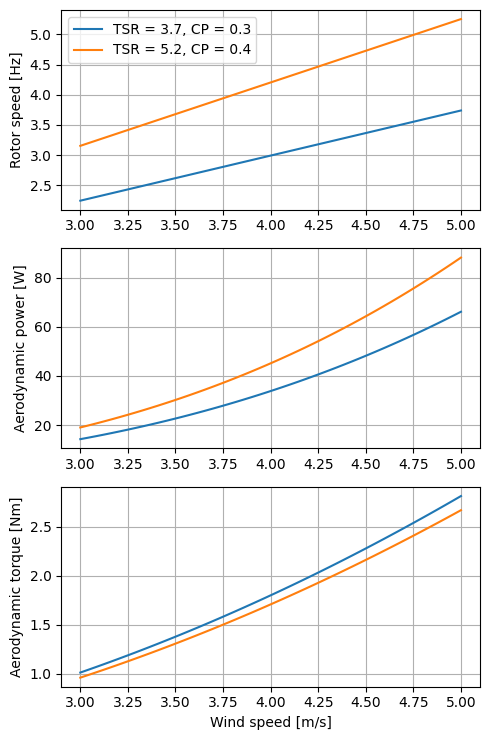

In [9]:
# things versus wind speed for different TSRs (CPs)
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(5, 7.5))
wsps = np.linspace(3, 5)

for (cp, tsr) in CP_TSRs:
    aero_power = 0.5 * RHO * cp * area * wsps**3 #  aerodynamic power[W]

    rot_speeds_radps = tsr * wsps / r  # rotor speeds [radps]
    rot_speeds_hz = rot_speeds_radps / 2 / np.pi  # rotor speed [Hz]

    aero_torque = aero_power / rot_speeds_radps  # aerodynamic torque [N]

    ax0.plot(wsps, rot_speeds_hz, label=f'TSR = {tsr}, CP = {cp}')
    ax1.plot(wsps, aero_power)
    ax2.plot(wsps, aero_torque)

ax0.set(ylabel='Rotor speed [Hz]')
ax1.set(ylabel='Aerodynamic power [W]')
ax2.set(xlabel='Wind speed [m/s]', ylabel='Aerodynamic torque [Nm]')
ax0.grid()
ax1.grid()
ax2.grid()
ax0.legend()
fig.tight_layout()